#### Load and process data

In [1]:
using AveragedCircuitEigenvalueSampling, StatsBase, LinearAlgebra, DataFrames, GLM, Optim
using Plots, Plots.PlotMeasures, StatsPlots, ColorSchemes, LaTeXStrings, JLD2, PrettyTables
# Set default plot parameters
pgfplotsx()
theme(:default, grid=false, fillalpha=0.5, tick_direction=:out, margins=0px,
    titlefontsize=10, guidefontsize=9, tickfontsize=7, legendfontsize=7)
push!(PGFPlotsX.CUSTOM_PREAMBLE, "\\usepackage{amsmath}")
push!(PGFPlotsX.CUSTOM_PREAMBLE, "\\usepackage{amssymb}")
# :tol_bright is a colourblind-friendly colourscheme
tol_bright = ColorSchemes.tol_bright
colour_series = [tol_bright[3]; tol_bright[1]; tol_bright[2]; tol_bright[4]; tol_bright[5]]
# In REVTeX, one column width is 246 pt, and the text width is 510 pt
col_width = 246.0
text_width = 510.0
aspect_ratio = 4 / 3
inches_per_pt = 1.0 / 72.27
default_dpi = 100.0
col_width_px = col_width * inches_per_pt * default_dpi
text_width_px = text_width * inches_per_pt * default_dpi
col_height_px = col_width_px / aspect_ratio
text_height_px = text_width_px / aspect_ratio
triple_height = (1 + 2 * (text_width / col_width - 1)) * col_width / aspect_ratio
triple_height_px = triple_height * inches_per_pt * default_dpi;

In [2]:
# Initialise data loading parameters
dist = 3
r_1 = 0.075 / 100
r_2 = 0.5 / 100
r_m = 2.0 / 100
total_std_log = sqrt(log(10 / 9))
seed = UInt(0)
rotated_param = RotatedPlanarParameters(dist)
dep_param = DepolarisingParameters(r_1, r_2, r_m)
log_param = LognormalParameters(r_1, r_2, r_m, total_std_log; seed=seed)
rotated_planar = Code(rotated_param, dep_param)
dist_max = 11
dist_range = collect(3:dist_max)
dense_range = collect(2:0.025:(dist_max+1))
# Load the metadata
metadata_dict = load("data/design_metadata_$(code_filename(rotated_param)).jld2")
@assert rotated_param == metadata_dict["rotated_param"]
@assert dep_param == metadata_dict["dep_param"]
dep_param_set = metadata_dict["dep_param_set"]
tuple_number_set = metadata_dict["tuple_number_set"]
repeat_numbers_set = metadata_dict["repeat_numbers_set"]
gls_tuple_number = metadata_dict["gls_tuple_number"]
gls_repeat_numbers = metadata_dict["gls_repeat_numbers"]
ols_tuple_number = metadata_dict["ols_tuple_number"]
ols_repeat_numbers = metadata_dict["ols_repeat_numbers"]
dep_idx = 14
@assert dep_param == dep_param_set[dep_idx]
dep_worst_idx = 3
wls_tuple_number = tuple_number_set[dep_idx]
wls_repeat_numbers = repeat_numbers_set[dep_idx]
wls_worst_tuple_number = tuple_number_set[dep_worst_idx]
wls_worst_repeat_numbers = repeat_numbers_set[dep_worst_idx]
triv_tuple_number = length(get_basic_tuple_set(rotated_planar))
triv_repeat_numbers = Int[]
# Load the data
dep_scaling_data_wls = load_scaling(rotated_param, dep_param, wls_tuple_number, wls_repeat_numbers, :wls, :dep)
log_scaling_data_wls = load_scaling(rotated_param, log_param, wls_tuple_number, wls_repeat_numbers, :wls, :log)
dep_scaling_data_gls = load_scaling(rotated_param, dep_param, gls_tuple_number, gls_repeat_numbers, :gls, :dep)
dep_scaling_data_ols = load_scaling(rotated_param, dep_param, ols_tuple_number, ols_repeat_numbers, :ols, :dep)
dep_scaling_data_wls_worst = load_scaling(rotated_param, dep_param, wls_worst_tuple_number, wls_worst_repeat_numbers, :wls, :dep);
dep_scaling_data_basic = load_scaling(rotated_param, dep_param, triv_tuple_number, triv_repeat_numbers, :wls, :dep);

In [3]:
# Fit the scaling data
# WLS depolarising
(
    wls_gate_number,
    wls_gate_params,
    wls_gate_eigenvalue_number,
    wls_gate_eigenvalue_params,
    wls_trace_fit,
    wls_trace_params,
    wls_trace_sq_fit,
    wls_trace_sq_params,
    wls_expectation_fit,
    wls_variance_fit,
) = depolarising_fits(dep_scaling_data_wls)
# WLS log-normal
(wls_expectation_fit_log, wls_variance_fit_log) =
    lognormal_fits(log_scaling_data_wls, wls_gate_eigenvalue_number, wls_trace_params, wls_trace_sq_params)
# GLS depolarising
(
    gls_gate_number,
    gls_gate_params,
    gls_gate_eigenvalue_number,
    gls_gate_eigenvalue_params,
    gls_trace_fit,
    gls_trace_params,
    gls_trace_sq_fit,
    gls_trace_sq_params,
    gls_expectation_fit,
    gls_variance_fit,
) = depolarising_fits(dep_scaling_data_gls)
@assert gls_gate_params == wls_gate_params
@assert gls_gate_eigenvalue_params == wls_gate_eigenvalue_params
# OLS depolarising
(
    ols_gate_number,
    ols_gate_params,
    ols_gate_eigenvalue_number,
    ols_gate_eigenvalue_params,
    ols_trace_fit,
    ols_trace_params,
    ols_trace_sq_fit,
    ols_trace_sq_params,
    ols_expectation_fit,
    ols_variance_fit,
) = depolarising_fits(dep_scaling_data_ols)
@assert ols_gate_params == wls_gate_params
@assert ols_gate_eigenvalue_params == wls_gate_eigenvalue_params
# Worst WLS depolarising
(
    wls_worst_gate_number,
    wls_worst_gate_params,
    wls_worst_gate_eigenvalue_number,
    wls_worst_gate_eigenvalue_params,
    wls_worst_trace_fit,
    wls_worst_trace_params,
    wls_worst_trace_sq_fit,
    wls_worst_trace_sq_params,
    wls_worst_expectation_fit,
    wls_worst_variance_fit,
) = depolarising_fits(dep_scaling_data_wls_worst)
@assert wls_worst_gate_params == wls_gate_params
@assert wls_worst_gate_eigenvalue_params == wls_gate_eigenvalue_params
# Trivial depolarising
(
    triv_gate_number,
    triv_gate_params,
    triv_gate_eigenvalue_number,
    triv_gate_eigenvalue_params,
    triv_trace_fit,
    triv_trace_params,
    triv_trace_sq_fit,
    triv_trace_sq_params,
    triv_expectation_fit,
    triv_variance_fit,
) = depolarising_fits(dep_scaling_data_basic)
@assert triv_gate_params == wls_gate_params
@assert triv_gate_eigenvalue_params == wls_gate_eigenvalue_params
println("The gate number as a function of code distance is: G(d) = $(wls_gate_params[1]) + $(wls_gate_params[2])d + $(wls_gate_params[3])d^2.")
println("The gate eigenvalue number as a function of code distance is: N(d) = $(wls_gate_eigenvalue_params[1]) + $(wls_gate_eigenvalue_params[2])d + $(wls_gate_eigenvalue_params[3])d^2.")

The gate number as a function of code distance is: G(d) = -10 + 4d + 16d^2.
The gate eigenvalue number as a function of code distance is: N(d) = -24 + -36d + 84d^2.


In [4]:
# Process the WLS depolarising data
@assert dep_scaling_data_wls.dist_range == dist_range
wls_expectation_scaling = [merit.expectation for merit in dep_scaling_data_wls.merit_scaling]
wls_variance_scaling = [merit.variance for merit in dep_scaling_data_wls.merit_scaling]
wls_stdev_scaling = [sqrt(merit.variance) for merit in dep_scaling_data_wls.merit_scaling]
wls_trace_scaling = [sum(merit.eigenvalues) for merit in dep_scaling_data_wls.merit_scaling]
wls_trace_sq_scaling = [sum(merit.eigenvalues .^ 2) for merit in dep_scaling_data_wls.merit_scaling]
wls_experiment_number_scaling = [merit.experiment_number for merit in dep_scaling_data_wls.merit_scaling]
wls_cond_num_scaling = [merit.cond_num for merit in dep_scaling_data_wls.merit_scaling]
wls_pinv_norm_scaling = [merit.pinv_norm for merit in dep_scaling_data_wls.merit_scaling]
wls_eigenvalues_scaling = [merit.eigenvalues for merit in dep_scaling_data_wls.merit_scaling]
# WLS data relative errors
wls_trace_fit_rel_error = (wls_trace_fit(dist_range) .- wls_trace_scaling) ./ wls_trace_scaling
wls_trace_sq_fit_rel_error = (wls_trace_sq_fit(dist_range) .- wls_trace_sq_scaling) ./ wls_trace_sq_scaling
wls_expectation_fit_rel_error = (wls_expectation_fit(dist_range) .- wls_expectation_scaling) ./ wls_expectation_scaling
wls_std_fit_rel_error = (sqrt.(wls_variance_fit(dist_range)) .- wls_stdev_scaling) ./ wls_stdev_scaling
# Print the relative errors of the fit
header = [
    "tr(Σ)"
    "tr(Σ²)"
    "Figure of merit"
    "NRMSE st. dev."
]
println("The relative errors of the fits for the WLS depolarising scaling data are:")
pretty_table(
    hcat(wls_trace_fit_rel_error, wls_trace_sq_fit_rel_error, wls_expectation_fit_rel_error, wls_std_fit_rel_error);
    header=header,
    alignment=:l,
    formatters=ft_printf("%.4e"),
)

The relative errors of the fits for the WLS depolarising scaling data are:
┌─────────────┬─────────────┬─────────────────┬────────────────┐
│ tr(Σ)       │ tr(Σ²)      │ Figure of merit │ NRMSE st. dev. │
├─────────────┼─────────────┼─────────────────┼────────────────┤
│ 7.6918e-09  │ 1.6476e-08  │ 3.8437e-09      │ 4.3914e-09     │
│ -4.3276e-09 │ -8.9202e-09 │ -2.1635e-09     │ -2.2962e-09    │
│ -1.1195e-09 │ -2.1938e-09 │ -5.5979e-10     │ -5.3716e-10    │
│ -2.8661e-11 │ -4.5953e-11 │ -1.4335e-11     │ -8.6471e-12    │
│ 2.9492e-10  │ 5.6948e-10  │ 1.4747e-10      │ 1.3729e-10     │
│ 3.0989e-10  │ 5.9009e-10  │ 1.5495e-10      │ 1.4010e-10     │
│ 1.9515e-10  │ 3.6821e-10  │ 9.7580e-11      │ 8.6531e-11     │
│ 2.7604e-11  │ 5.1283e-11  │ 1.3803e-11      │ 1.1840e-11     │
│ -1.5764e-10 │ -2.9505e-10 │ -7.8822e-11     │ -6.8708e-11    │
└─────────────┴─────────────┴─────────────────┴────────────────┘


In [5]:
# Process the GLS depolarising data
@assert dep_scaling_data_gls.dist_range == dist_range
gls_expectation_scaling = [merit.expectation for merit in dep_scaling_data_gls.merit_scaling]
gls_variance_scaling = [merit.variance for merit in dep_scaling_data_gls.merit_scaling]
gls_stdev_scaling = [sqrt(merit.variance) for merit in dep_scaling_data_gls.merit_scaling]
gls_trace_scaling = [sum(merit.eigenvalues) for merit in dep_scaling_data_gls.merit_scaling]
gls_trace_sq_scaling = [sum(merit.eigenvalues .^ 2) for merit in dep_scaling_data_gls.merit_scaling]
gls_experiment_number_scaling = [merit.experiment_number for merit in dep_scaling_data_gls.merit_scaling]
gls_cond_num_scaling = [merit.cond_num for merit in dep_scaling_data_gls.merit_scaling]
gls_pinv_norm_scaling = [merit.pinv_norm for merit in dep_scaling_data_gls.merit_scaling]
gls_eigenvalues_scaling = [merit.eigenvalues for merit in dep_scaling_data_gls.merit_scaling]
# GLS data relative errors
gls_trace_fit_rel_error = (gls_trace_fit(dist_range) .- gls_trace_scaling) ./ gls_trace_scaling
gls_trace_sq_fit_rel_error = (gls_trace_sq_fit(dist_range) .- gls_trace_sq_scaling) ./ gls_trace_sq_scaling
gls_expectation_fit_rel_error = (gls_expectation_fit(dist_range) .- gls_expectation_scaling) ./ gls_expectation_scaling
gls_std_fit_rel_error = (sqrt.(gls_variance_fit(dist_range)) .- gls_stdev_scaling) ./ gls_stdev_scaling
# Print the relative errors of the fit
header = [
    "tr(Σ)"
    "tr(Σ²)"
    "Figure of merit"
    "NRMSE st. dev."
]
println("The relative errors of the fits for the GLS depolarising scaling data are:")
pretty_table(
    hcat(gls_trace_fit_rel_error, gls_trace_sq_fit_rel_error, gls_expectation_fit_rel_error, gls_std_fit_rel_error);
    header=header,
    alignment=:l,
    formatters=ft_printf("%.4e"),
)

The relative errors of the fits for the GLS depolarising scaling data are:
┌─────────────┬─────────────┬─────────────────┬────────────────┐
│ tr(Σ)       │ tr(Σ²)      │ Figure of merit │ NRMSE st. dev. │
├─────────────┼─────────────┼─────────────────┼────────────────┤
│ 4.1294e-04  │ 1.3894e-03  │ 2.0542e-04      │ 4.8764e-04     │
│ -2.5138e-04 │ -1.4190e-03 │ -1.2483e-04     │ -5.8392e-04    │
│ 1.7110e-05  │ 3.9835e-04  │ 8.3438e-06      │ 1.9055e-04     │
│ -9.4590e-05 │ -3.6570e-04 │ -4.7227e-05     │ -1.3556e-04    │
│ 5.4133e-05  │ 6.4443e-04  │ 2.6915e-05      │ 2.9505e-04     │
│ -5.9634e-05 │ -4.8597e-04 │ -2.9740e-05     │ -2.1319e-04    │
│ 1.8321e-04  │ 5.1701e-04  │ 9.1578e-05      │ 1.6684e-04     │
│ -1.3463e-04 │ -4.5067e-04 │ -6.7294e-05     │ -1.5805e-04    │
│ 2.7458e-05  │ 1.3941e-04  │ 1.3720e-05      │ 5.5971e-05     │
└─────────────┴─────────────┴─────────────────┴────────────────┘


In [6]:
# Process the OLS depolarising data
@assert dep_scaling_data_ols.dist_range == dist_range
ols_expectation_scaling = [merit.expectation for merit in dep_scaling_data_ols.merit_scaling]
ols_variance_scaling = [merit.variance for merit in dep_scaling_data_ols.merit_scaling]
ols_stdev_scaling = [sqrt(merit.variance) for merit in dep_scaling_data_ols.merit_scaling]
ols_trace_scaling = [sum(merit.eigenvalues) for merit in dep_scaling_data_ols.merit_scaling]
ols_trace_sq_scaling = [sum(merit.eigenvalues .^ 2) for merit in dep_scaling_data_ols.merit_scaling]
ols_experiment_number_scaling = [merit.experiment_number for merit in dep_scaling_data_ols.merit_scaling]
ols_cond_num_scaling = [merit.cond_num for merit in dep_scaling_data_ols.merit_scaling]
ols_pinv_norm_scaling = [merit.pinv_norm for merit in dep_scaling_data_ols.merit_scaling]
ols_eigenvalues_scaling = [merit.eigenvalues for merit in dep_scaling_data_ols.merit_scaling]
# OLS data relative errors
ols_trace_fit_rel_error = (ols_trace_fit(dist_range) .- ols_trace_scaling) ./ ols_trace_scaling
ols_trace_sq_fit_rel_error = (ols_trace_sq_fit(dist_range) .- ols_trace_sq_scaling) ./ ols_trace_sq_scaling
ols_expectation_fit_rel_error = (ols_expectation_fit(dist_range) .- ols_expectation_scaling) ./ ols_expectation_scaling
ols_std_fit_rel_error = (sqrt.(ols_variance_fit(dist_range)) .- ols_stdev_scaling) ./ ols_stdev_scaling
# Print the relative errors of the fit
header = [
    "tr(Σ)"
    "tr(Σ²)"
    "Figure of merit"
    "NRMSE st. dev."
]
println("The relative errors of the fits for the OLS depolarising scaling data are:")
pretty_table(
    hcat(ols_trace_fit_rel_error, ols_trace_sq_fit_rel_error, ols_expectation_fit_rel_error, ols_std_fit_rel_error);
    header=header,
    alignment=:l,
    formatters=ft_printf("%.4e"),
)

The relative errors of the fits for the OLS depolarising scaling data are:
┌─────────────┬─────────────┬─────────────────┬────────────────┐
│ tr(Σ)       │ tr(Σ²)      │ Figure of merit │ NRMSE st. dev. │
├─────────────┼─────────────┼─────────────────┼────────────────┤
│ 3.0584e-07  │ 3.1685e-07  │ 1.5344e-07      │ 5.6293e-09     │
│ -1.6771e-07 │ -1.7273e-07 │ -8.4002e-08     │ -2.5481e-09    │
│ -5.1779e-08 │ -5.1621e-08 │ -2.5918e-08     │ 7.1801e-11     │
│ -2.7306e-09 │ -2.3890e-09 │ -1.3664e-09     │ 1.7048e-10     │
│ 1.2547e-08  │ 1.2605e-08  │ 6.2767e-09      │ 3.0059e-11     │
│ 1.3691e-08  │ 1.3607e-08  │ 6.8482e-09      │ -4.1216e-11    │
│ 8.7742e-09  │ 8.6746e-09  │ 4.3885e-09      │ -4.9422e-11    │
│ 1.3251e-09  │ 1.2898e-09  │ 6.6273e-10      │ -1.7596e-11    │
│ -7.0229e-09 │ -6.9470e-09 │ -3.5122e-09     │ 3.7752e-11     │
└─────────────┴─────────────┴─────────────────┴────────────────┘


In [7]:
# Process the worst WLS depolarising data
@assert dep_scaling_data_wls_worst.dist_range == dist_range
wls_worst_expectation_scaling = [merit.expectation for merit in dep_scaling_data_wls_worst.merit_scaling]
wls_worst_variance_scaling = [merit.variance for merit in dep_scaling_data_wls_worst.merit_scaling]
wls_worst_stdev_scaling = [sqrt(merit.variance) for merit in dep_scaling_data_wls_worst.merit_scaling]
wls_worst_trace_scaling = [sum(merit.eigenvalues) for merit in dep_scaling_data_wls_worst.merit_scaling]
wls_worst_trace_sq_scaling = [sum(merit.eigenvalues .^ 2) for merit in dep_scaling_data_wls_worst.merit_scaling]
wls_worst_experiment_number_scaling = [merit.experiment_number for merit in dep_scaling_data_wls_worst.merit_scaling]
wls_worst_cond_num_scaling = [merit.cond_num for merit in dep_scaling_data_wls_worst.merit_scaling]
wls_worst_pinv_norm_scaling = [merit.pinv_norm for merit in dep_scaling_data_wls_worst.merit_scaling]
wls_worst_eigenvalues_scaling = [merit.eigenvalues for merit in dep_scaling_data_wls_worst.merit_scaling]
# Worst WLS data relative errors
wls_worst_trace_fit_rel_error = (wls_worst_trace_fit(dist_range) .- wls_worst_trace_scaling) ./ wls_worst_trace_scaling
wls_worst_trace_sq_fit_rel_error = (wls_worst_trace_sq_fit(dist_range) .- wls_worst_trace_sq_scaling) ./ wls_worst_trace_sq_scaling
wls_worst_expectation_fit_rel_error = (wls_worst_expectation_fit(dist_range) .- wls_worst_expectation_scaling) ./ wls_worst_expectation_scaling
wls_worst_std_fit_rel_error = (sqrt.(wls_worst_variance_fit(dist_range)) .- wls_worst_stdev_scaling) ./ wls_worst_stdev_scaling
# Print the relative errors of the fit
header = [
    "tr(Σ)"
    "tr(Σ²)"
    "Figure of merit"
    "NRMSE st. dev."
]
println("The relative errors of the fits for the worst WLS depolarising scaling data are:")
pretty_table(
    hcat(wls_worst_trace_fit_rel_error, wls_worst_trace_sq_fit_rel_error, wls_worst_expectation_fit_rel_error, wls_worst_std_fit_rel_error);
    header=header,
    alignment=:l,
    formatters=ft_printf("%.4e"),
)

The relative errors of the fits for the worst WLS depolarising scaling data are:
┌─────────────┬─────────────┬─────────────────┬────────────────┐
│ tr(Σ)       │ tr(Σ²)      │ Figure of merit │ NRMSE st. dev. │
├─────────────┼─────────────┼─────────────────┼────────────────┤
│ 1.6690e-09  │ 5.4798e-09  │ 8.3141e-10      │ 1.9046e-09     │
│ -9.4874e-10 │ -3.0426e-09 │ -4.7349e-10     │ -1.0467e-09    │
│ -2.4312e-10 │ -6.8895e-10 │ -1.2146e-10     │ -2.2289e-10    │
│ -6.2082e-12 │ -3.8571e-12 │ -3.1066e-12     │ 1.1747e-12     │
│ 6.4820e-11  │ 1.8906e-10  │ 3.2396e-11      │ 6.2115e-11     │
│ 6.8192e-11  │ 1.9274e-10  │ 3.4086e-11      │ 6.2271e-11     │
│ 4.2982e-11  │ 1.1943e-10  │ 2.1486e-11      │ 3.8223e-11     │
│ 6.0783e-12  │ 1.6055e-11  │ 3.0387e-12      │ 4.9879e-12     │
│ -3.4783e-11 │ -9.6489e-11 │ -1.7389e-11     │ -3.0852e-11    │
└─────────────┴─────────────┴─────────────────┴────────────────┘


In [8]:
# Process the trivial design depolarising data
@assert dep_scaling_data_basic.dist_range == dist_range
triv_expectation_scaling = [merit.expectation for merit in dep_scaling_data_basic.merit_scaling]
triv_variance_scaling = [merit.variance for merit in dep_scaling_data_basic.merit_scaling]
triv_stdev_scaling = [sqrt(merit.variance) for merit in dep_scaling_data_basic.merit_scaling]
triv_trace_scaling = [sum(merit.eigenvalues) for merit in dep_scaling_data_basic.merit_scaling]
triv_trace_sq_scaling = [sum(merit.eigenvalues .^ 2) for merit in dep_scaling_data_basic.merit_scaling]
triv_experiment_number_scaling = [merit.experiment_number for merit in dep_scaling_data_basic.merit_scaling]
triv_cond_num_scaling = [merit.cond_num for merit in dep_scaling_data_basic.merit_scaling]
triv_pinv_norm_scaling = [merit.pinv_norm for merit in dep_scaling_data_basic.merit_scaling]
triv_eigenvalues_scaling = [merit.eigenvalues for merit in dep_scaling_data_basic.merit_scaling]
# Trivial design data relative errors
triv_trace_fit_rel_error = (triv_trace_fit(dist_range) .- triv_trace_scaling) ./ triv_trace_scaling
triv_trace_sq_fit_rel_error = (triv_trace_sq_fit(dist_range) .- triv_trace_sq_scaling) ./ triv_trace_sq_scaling
triv_expectation_fit_rel_error = (triv_expectation_fit(dist_range) .- triv_expectation_scaling) ./ triv_expectation_scaling
triv_std_fit_rel_error = (sqrt.(triv_variance_fit(dist_range)) .- triv_stdev_scaling) ./ triv_stdev_scaling
# Print the relative errors of the fit
header = [
    "tr(Σ)"
    "tr(Σ²)"
    "Figure of merit"
    "NRMSE st. dev."
]
println("The relative errors of the fits for the trivial design depolarising scaling data are:")
pretty_table(
    hcat(triv_trace_fit_rel_error, triv_trace_sq_fit_rel_error, triv_expectation_fit_rel_error, triv_std_fit_rel_error);
    header=header,
    alignment=:l,
    formatters=ft_printf("%.4e"),
)

The relative errors of the fits for the trivial design depolarising scaling data are:
┌─────────────┬─────────────┬─────────────────┬────────────────┐
│ tr(Σ)       │ tr(Σ²)      │ Figure of merit │ NRMSE st. dev. │
├─────────────┼─────────────┼─────────────────┼────────────────┤
│ 1.5352e-14  │ 2.3695e-14  │ 7.6833e-15      │ 4.0291e-15     │
│ 0.0000e+00  │ 2.9855e-15  │ 0.0000e+00      │ 1.4249e-15     │
│ -3.2003e-15 │ -3.7626e-15 │ -1.6072e-15     │ -3.5752e-16    │
│ -3.1199e-15 │ -2.9860e-15 │ -1.4876e-15     │ 0.0000e+00     │
│ -2.5027e-15 │ -2.5590e-15 │ -1.0275e-15     │ 0.0000e+00     │
│ -2.0810e-15 │ -2.8144e-15 │ -1.0258e-15     │ -4.3071e-16    │
│ -4.4409e-16 │ 3.9793e-16  │ -2.2767e-16     │ 4.8481e-16     │
│ 3.5697e-16  │ -1.2732e-15 │ 3.4115e-16      │ -8.9814e-16    │
│ 1.7592e-15  │ 2.7341e-15  │ 1.0226e-15      │ 3.9529e-16     │
└─────────────┴─────────────┴─────────────────┴────────────────┘


In [9]:
# Process the WLS lognormal data
@assert log_scaling_data_wls.dist_range == dist_range
repetitions = length.(log_scaling_data_wls.expectation_scaling)
@assert repetitions == length.(log_scaling_data_wls.variance_scaling)
wls_expectation_scaling_log = log_scaling_data_wls.expectation_scaling
wls_mean_expectation_scaling_log = mean.(wls_expectation_scaling_log)
wls_std_expectation_scaling_log = std.(wls_expectation_scaling_log)
wls_sem_expectation_scaling_log = wls_std_expectation_scaling_log ./ sqrt.(repetitions)
wls_stdev_scaling_log = [sqrt.(variances) for variances in log_scaling_data_wls.variance_scaling]
wls_mean_stdev_scaling_log = mean.(wls_stdev_scaling_log)
wls_std_stdev_scaling_log = std.(wls_stdev_scaling_log)
wls_sem_stdev_scaling_log = wls_std_stdev_scaling_log ./ sqrt.(repetitions)
# WLS data relative errors
wls_expectation_log_fit_rel_error = (wls_expectation_fit_log(dist_range) .- wls_mean_expectation_scaling_log) ./ wls_mean_expectation_scaling_log
wls_std_log_fit_rel_error = (sqrt.(wls_variance_fit_log(dist_range)) .- wls_mean_stdev_scaling_log) ./ wls_mean_stdev_scaling_log
# Print the relative errors of the fit
header = [
    "Figure of merit"
    "NRMSE st. dev."
]
println("The relative errors of the fits for the WLS mean of the lognormal scaling data are:")
pretty_table(
    hcat(wls_expectation_log_fit_rel_error, wls_std_log_fit_rel_error);
    header=header,
    alignment=:l,
    formatters=ft_printf("%.4e"),
)

The relative errors of the fits for the WLS mean of the lognormal scaling data are:
┌─────────────────┬────────────────┐
│ Figure of merit │ NRMSE st. dev. │
├─────────────────┼────────────────┤
│ -1.4537e-04     │ 5.2956e-04     │
│ 3.9889e-04      │ 4.6376e-04     │
│ -1.8478e-04     │ -3.8862e-04    │
│ 4.8529e-04      │ 8.5672e-04     │
│ -2.3277e-04     │ -2.2680e-04    │
│ -7.6218e-04     │ -4.5611e-05    │
│ -3.1590e-04     │ -1.8731e-04    │
│ -9.8704e-06     │ -3.2502e-05    │
│ 7.6846e-04      │ 5.2232e-04     │
└─────────────────┴────────────────┘


#### Plotting the figure of merit as a function of the code distance

#### Figure 4: Figure of merit and NRMSE standard deviation of the WLS design as a function of code distance, with both the data and fits, for depolarising noise and an average over random instances of log-normal Pauli noise

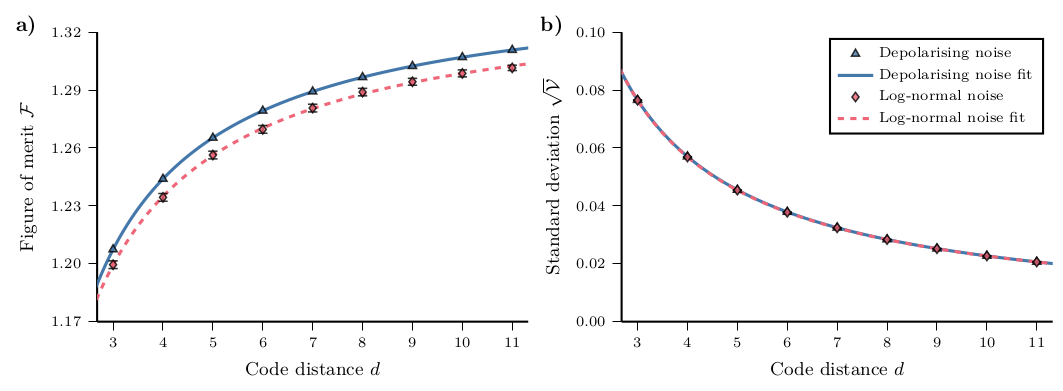

In [10]:
# Plot the figure of merit and NRMSE standard deviation as a function of code distance, including fits, for depolarising and lognormal noise
pad = 0.08
x_min = 3
x_int = 1
x_max = dist_max
theme(:default, grid=false, fillalpha=0.5, tick_direction=:out, margins=0px,
    titlefontsize=10, guidefontsize=9, tickfontsize=7, legendfontsize=7,
    palette=reverse(colour_series[1:4]), markersize=3, markeralpha=0.8,
    xlims=(x_min, x_max), xticks=x_min:x_int:x_max,
    xguide=L"\textrm{Code distance }d", xwiden=1 + pad,
    legend=:topright, legend_font_halign=:left)
# Figure of merit plot
y_min = 1.17
y_max = 1.32
y_int = 0.03
expectation_plot = scatter(dist_range, wls_expectation_scaling;
    ylims=(y_min, y_max), yticks=y_min:y_int:y_max,
    yguide=L"\textrm{Figure of merit }\mathcal{F}",
    markershape=:utriangle, color=colour_series[2], label="Depolarising noise",
    legend=false,
)
plot!(dense_range, wls_expectation_fit(dense_range);
    linestyle=:solid,
    linewidth=1.5,
    color=colour_series[2],
    label="Depolarising noise fit",
)
scatter!(dist_range, wls_mean_expectation_scaling_log;
    yerror=2 * wls_sem_expectation_scaling_log,
    markershape=:diamond,
    color=colour_series[3],
    label="Log-normal noise",
)
plot!(dense_range, wls_expectation_fit_log(dense_range);
    linestyle=:dash,
    linewidth=1.5,
    color=colour_series[3],
    label="Log-normal noise fit",
    extra_kwargs=:plot, add=raw"
    \node[anchor=south west] at (0.0-1.5,0.0-0.2) {\textbf{a)}};
    \node[anchor=south west] at (8.88-1.5,0.0-0.2) {\textbf{b)}};
")
# \node at (0.0,0.0) {\textbf{o}};
# \node at (8.88,0.0) {\textbf{o}};
# Standard deviation plot
y_min = 0.0
y_max = 0.10
y_int = 0.02
stdev_plot = scatter(dist_range, wls_stdev_scaling;
    ylims=(y_min, y_max), yticks=y_min:y_int:y_max,
    yguide=L"\textrm{Standard deviation }\sqrt{\mathcal{V}}",
    markershape=:utriangle,
    color=colour_series[2],
    label="Depolarising noise",
)
plot!(dense_range, sqrt.(wls_variance_fit(dense_range));
    linestyle=:solid,
    linewidth=1.5,
    color=colour_series[2],
    label="Depolarising noise fit",
)
scatter!(dist_range, wls_mean_stdev_scaling_log;
    yerror=2 * wls_sem_stdev_scaling_log,
    markershape=:diamond,
    color=colour_series[3],
    label="Log-normal noise",
)
plot!(dense_range, sqrt.(wls_variance_fit_log(dense_range));
    linestyle=:dash,
    linewidth=1.5,
    color=colour_series[3],
    label="Log-normal noise fit",
)
# Combined plot
combined_plot = plot(expectation_plot, stdev_plot; layout=(1, 2), size=(text_width_px * 0.991, col_height_px))
savefig(combined_plot, pwd() * "/figures/nrmse_scaling_$(rotated_param.code_name).pdf")
display(combined_plot)

#### Figure 5: Histogram of the figure of merit of the WLS design over random instances of log-normal Pauli noise as a function of code distance

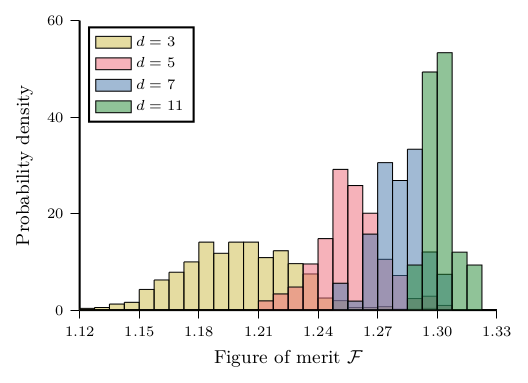

In [11]:
# Histogram of the figure of merit across instances of lognormal noise as a function of code distance
log_hist = histogram(
    wls_expectation_scaling_log[[1; 3; 5; 9]];
    labels=hcat([L"d = %$(d)" for d in dist_range[[1; 3; 5; 9]]]...),
    xlims=(1.12, 1.33), xticks=1.12:0.03:1.33, xwiden=1,
    xguide=L"\textrm{Figure of merit }\mathcal{F}",
    ylims=(0, 60), yticks=0:20:60,
    yguide="Probability density",
    bins=1.12:0.0075:1.33, normalize=:pdf,
    linewidth=0.5, legend=:topleft,
    size=(col_width_px, col_height_px),
)
plot_xlims = xlims(log_hist)
@assert plot_xlims[1] < minimum(minimum(wls_expectation_scaling_log)) && plot_xlims[2] > maximum(maximum(wls_expectation_scaling_log))
savefig(log_hist, pwd() * "/figures/nrmse_scaling_hist_$(rotated_param.code_name).pdf")
display(log_hist)

#### Confirming fit parameterisation with the corrected Akaike information criterion

In [12]:
# Compare the AICc of different fit parameterisations
wls_trace_data = DataFrame(y=wls_trace_scaling, x=dist_range)
wls_trace_constant_model = lm(@formula(y ~ 1), wls_trace_data)
wls_trace_linear_model = lm(@formula(y ~ 1 + x), wls_trace_data)
wls_trace_quadratic_model = lm(@formula(y ~ 1 + x + x^2), wls_trace_data)
wls_trace_cubic_model = lm(@formula(y ~ 1 + x + x^2 + x^3), wls_trace_data)
wls_trace_quartic_model = lm(@formula(y ~ 1 + x + x^2 + x^3 + x^4), wls_trace_data)
wls_trace_aicc = [aicc(wls_trace_constant_model); aicc(wls_trace_linear_model); aicc(wls_trace_quadratic_model); aicc(wls_trace_cubic_model); aicc(wls_trace_quartic_model)]
wls_trace_sq_data = DataFrame(y=wls_trace_sq_scaling, x=dist_range)
wls_trace_sq_constant_model = lm(@formula(y ~ 1), wls_trace_sq_data)
wls_trace_sq_linear_model = lm(@formula(y ~ 1 + x), wls_trace_sq_data)
wls_trace_sq_quadratic_model = lm(@formula(y ~ 1 + x + x^2), wls_trace_sq_data)
wls_trace_sq_cubic_model = lm(@formula(y ~ 1 + x + x^2 + x^3), wls_trace_sq_data)
wls_trace_sq_quartic_model = lm(@formula(y ~ 1 + x + x^2 + x^3 + x^4), wls_trace_sq_data)
wls_trace_sq_aicc = [aicc(wls_trace_sq_constant_model); aicc(wls_trace_sq_linear_model); aicc(wls_trace_sq_quadratic_model); aicc(wls_trace_sq_cubic_model); aicc(wls_trace_sq_quartic_model)]
# Print AICc
header = [
    "Model"
    "AICc"
]
model_types = ["Constant"; "Linear"; "Quadratic"; "Cubic"; "Quartic"]
println("The corrected Akaike information criteria of polynomial fits of tr(Σ) are:")
pretty_table(
    hcat(model_types, wls_trace_aicc);
    header=header,
    alignment=:l,
    formatters=ft_printf("%.2f"),
)
println("The corrected Akaike information criteria of polynomial fits of tr(Σ²) are:")
pretty_table(
    hcat(model_types, wls_trace_sq_aicc);
    header=header,
    alignment=:l,
    formatters=ft_printf("%.2f"),
)
println("The quadratic model is best according to the AICc in both instances.")

The corrected Akaike information criteria of polynomial fits of tr(Σ) are:
┌───────────┬─────────┐
│ Model     │ AICc    │
├───────────┼─────────┤
│ Constant  │ 185.51  │
│ Linear    │ 158.65  │
│ Quadratic │ -180.10 │
│ Cubic     │ -176.01 │
│ Quartic   │ -162.65 │
└───────────┴─────────┘
The corrected Akaike information criteria of polynomial fits of tr(Σ²) are:
┌───────────┬─────────┐
│ Model     │ AICc    │
├───────────┼─────────┤
│ Constant  │ 223.76  │
│ Linear    │ 197.55  │
│ Quadratic │ -130.55 │
│ Cubic     │ -126.33 │
│ Quartic   │ -112.82 │
└───────────┴─────────┘
The quadratic model is best according to the AICc in both instances.


#### Plotting and displaying various quantities as a function of code distance across the different designs

In [13]:
# Initialise data
plot_labels = [L"\mathrm{GLS}", L"\mathrm{WLS}", L"\mathrm{WLS}^*", L"\mathrm{OLS}"]
labels = ["GLS", "WLS", "WLS (misoptim.)", "OLS", "Basic (WLS)"]
marker_shapes = [:diamond, :utriangle, :dtriangle, :pentagon]
expectation_set = [gls_expectation_scaling, wls_expectation_scaling, wls_worst_expectation_scaling, ols_expectation_scaling, triv_expectation_scaling]
expectation_fit_set = [gls_expectation_fit, wls_expectation_fit, wls_worst_expectation_fit, ols_expectation_fit, triv_expectation_fit]
stdev_set = [gls_stdev_scaling, wls_stdev_scaling, wls_worst_stdev_scaling, ols_stdev_scaling, triv_stdev_scaling]
stdev_fit_set = [gls_variance_fit, wls_variance_fit, wls_worst_variance_fit, ols_variance_fit, triv_variance_fit]
experiment_number_set = [gls_experiment_number_scaling, wls_experiment_number_scaling, wls_worst_experiment_number_scaling, ols_experiment_number_scaling, triv_experiment_number_scaling]
cond_num_set = [gls_cond_num_scaling, wls_cond_num_scaling, wls_worst_cond_num_scaling, ols_cond_num_scaling, triv_cond_num_scaling]
pinv_norm_set = [gls_pinv_norm_scaling, wls_pinv_norm_scaling, wls_worst_pinv_norm_scaling, ols_pinv_norm_scaling, triv_pinv_norm_scaling];

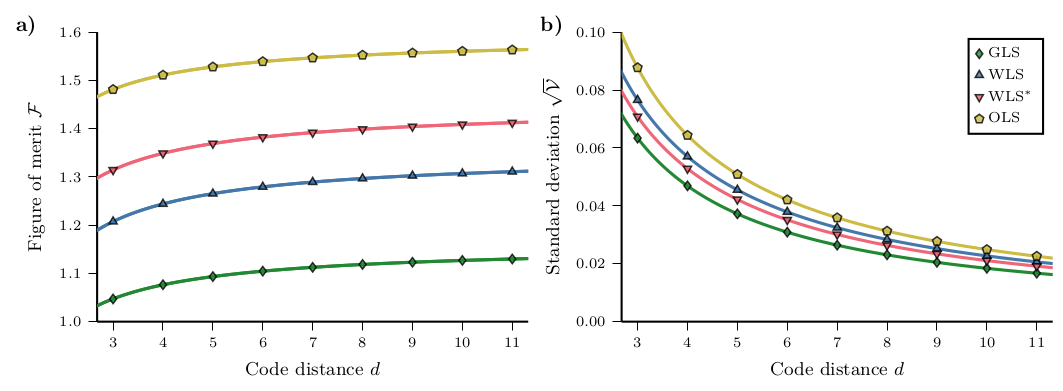

In [14]:
# Plot the figure of merit and NRMSE standard deviation as a function of code distance, including fits, for depolarising noise and a range of designs
# Figure of merit plot
y_min = 1.0
y_max = 1.6
y_int = 0.1
expectation_set_plot = plot(; ylims=(y_min, y_max), yticks=y_min:y_int:y_max,
    yguide=L"\textrm{Figure of merit }\mathcal{F}",
    legend=false,
)
for idx in 1:4
    scatter!(dist_range, expectation_set[idx];
        markershape=marker_shapes[idx],
        color=colour_series[idx],
    )
    plot!(dense_range, expectation_fit_set[idx](dense_range);
        linestyle=:solid, linewidth=1.5,
        color=colour_series[idx],
    )
    if idx == 4
        plot!(dense_range, expectation_fit_set[idx](dense_range);
            linestyle=:solid, linewidth=1.5,
            color=colour_series[idx],
            extra_kwargs=:plot, add=raw"
            \node[anchor=south west] at (0.0-1.5,0.0-0.2) {\textbf{a)}};
            \node[anchor=south west] at (8.88-1.5,0.0-0.2) {\textbf{b)}};
            ")
        # \node at (0.0,0.0) {\textbf{o}};
        # \node at (8.88,0.0) {\textbf{o}};
    else
        plot!(dense_range, expectation_fit_set[idx](dense_range);
            linestyle=:solid, linewidth=1.5,
            color=colour_series[idx],
        )
    end
end
# Variance plot
y_min = 0.0
y_max = 0.10
y_int = 0.02
stdev_set_plot = plot(; ylims=(y_min, y_max), yticks=y_min:y_int:y_max,
    yguide=L"\textrm{Standard deviation }\sqrt{\mathcal{V}}",
)
for idx in 1:4
    scatter!(dist_range, stdev_set[idx];
        markershape=marker_shapes[idx],
        color=colour_series[idx],
        label=plot_labels[idx],
    )
    plot!(dense_range, sqrt.(stdev_fit_set[idx](dense_range));
        linestyle=:solid, linewidth=1.5,
        color=colour_series[idx],
        label=nothing,
    )
end
# Combined plot
combined_set_plot = plot(expectation_set_plot, stdev_set_plot; size=(text_width_px * 0.991, col_height_px))
savefig(combined_set_plot, pwd() * "/figures/nrmse_scaling_$(rotated_param.code_name)_combined.pdf")
display(combined_set_plot)

In [15]:
# Tables of the figure of merit and NRMSE standard deviation
println("The figures of merit for depolarising noise across a range of designs and code distances are:")
pretty_table(
    hcat([[dist_range]; expectation_set]...);
    header=["d"; labels],
    alignment=:l,
    formatters=(ft_printf("%i", 1), ft_printf("%.4f"))
)
println("The NRMSE standard deviations for depolarising noise across a range of designs and code distances are:")
pretty_table(
    hcat([[dist_range]; stdev_set]...);
    header=["d"; labels],
    alignment=:l,
    formatters=(ft_printf("%i", 1), ft_printf("%.4f"))
)

The figures of merit for depolarising noise across a range of designs and code distances are:
┌────┬────────┬────────┬─────────────────┬────────┬─────────────┐
│ d  │ GLS    │ WLS    │ WLS (misoptim.) │ OLS    │ Basic (WLS) │
├────┼────────┼────────┼─────────────────┼────────┼─────────────┤
│ 3  │ 1.0470 │ 1.2074 │ 1.3144          │ 1.4811 │ 3.8148      │
│ 4  │ 1.0765 │ 1.2439 │ 1.3488          │ 1.5109 │ 3.8490      │
│ 5  │ 1.0934 │ 1.2652 │ 1.3690          │ 1.5279 │ 3.8684      │
│ 6  │ 1.1047 │ 1.2793 │ 1.3823          │ 1.5389 │ 3.8809      │
│ 7  │ 1.1125 │ 1.2892 │ 1.3918          │ 1.5466 │ 3.8897      │
│ 8  │ 1.1186 │ 1.2966 │ 1.3988          │ 1.5523 │ 3.8962      │
│ 9  │ 1.1230 │ 1.3024 │ 1.4043          │ 1.5568 │ 3.9012      │
│ 10 │ 1.1269 │ 1.3070 │ 1.4087          │ 1.5603 │ 3.9052      │
│ 11 │ 1.1298 │ 1.3107 │ 1.4123          │ 1.5632 │ 3.9084      │
└────┴────────┴────────┴─────────────────┴────────┴─────────────┘
The NRMSE standard deviations for depolarising n

In [16]:
# Table of experiment numbers
println("The experiment numbers across a range of designs and code distances are:")
pretty_table(hcat([[dist_range]; experiment_number_set]...); header=["d"; labels], alignment=:l)
println("Almost all of these values are constant with code distance, and they saturate at distance 8.")

The experiment numbers across a range of designs and code distances are:
┌────┬─────┬─────┬─────────────────┬─────┬─────────────┐
│ d  │ GLS │ WLS │ WLS (misoptim.) │ OLS │ Basic (WLS) │
├────┼─────┼─────┼─────────────────┼─────┼─────────────┤
│ 3  │ 922 │ 846 │ 1092            │ 774 │ 168         │
│ 4  │ 934 │ 846 │ 1092            │ 774 │ 168         │
│ 5  │ 934 │ 846 │ 1092            │ 774 │ 168         │
│ 6  │ 938 │ 846 │ 1092            │ 774 │ 168         │
│ 7  │ 938 │ 846 │ 1092            │ 774 │ 168         │
│ 8  │ 942 │ 846 │ 1092            │ 774 │ 168         │
│ 9  │ 942 │ 846 │ 1092            │ 774 │ 168         │
│ 10 │ 942 │ 846 │ 1092            │ 774 │ 168         │
│ 11 │ 942 │ 846 │ 1092            │ 774 │ 168         │
└────┴─────┴─────┴─────────────────┴─────┴─────────────┘
Almost all of these values are constant with code distance, and they saturate at distance 8.


In [17]:
# Table of condition numbers and pseudoinverse norms
println("The design matrix condition numbers across a range of designs and code distances are:")
pretty_table(
    hcat([[dist_range]; cond_num_set]...);
    header=["d"; labels],
    alignment=:l,
    formatters=(ft_printf("%i", 1), ft_printf("%.2f"))
)
println("The design matrix pseudoinverse norms across a range of designs and code distances are:")
pretty_table(
    hcat([[dist_range]; pinv_norm_set]...);
    header=["d"; labels],
    alignment=:l,
    formatters=(ft_printf("%i", 1), ft_printf("%.4f"))
)
println("""
The condition numbers and pseudoinverse norms do not substantially change with code distance.
The trivial design has the best condition number despite performing by far the worst.
The optimised WLS design has a worse pseudoinverse norm than the worst-performing WLS design optimised for different noise parameters, despite performing better on the noise parameters of interest.""")

The design matrix condition numbers across a range of designs and code distances are:
┌────┬────────┬────────┬─────────────────┬────────┬─────────────┐
│ d  │ GLS    │ WLS    │ WLS (misoptim.) │ OLS    │ Basic (WLS) │
├────┼────────┼────────┼─────────────────┼────────┼─────────────┤
│ 3  │ 205.29 │ 209.10 │ 403.26          │ 101.23 │ 29.39       │
│ 4  │ 209.37 │ 213.76 │ 411.34          │ 101.53 │ 30.97       │
│ 5  │ 211.27 │ 216.18 │ 416.46          │ 101.68 │ 31.70       │
│ 6  │ 212.32 │ 217.69 │ 420.04          │ 101.77 │ 32.09       │
│ 7  │ 212.97 │ 218.73 │ 422.59          │ 101.83 │ 32.33       │
│ 8  │ 213.41 │ 219.48 │ 424.45          │ 101.87 │ 32.48       │
│ 9  │ 213.73 │ 220.05 │ 425.85          │ 101.90 │ 32.59       │
│ 10 │ 213.98 │ 220.49 │ 426.93          │ 101.92 │ 32.66       │
│ 11 │ 214.17 │ 220.84 │ 427.77          │ 101.94 │ 32.71       │
└────┴────────┴────────┴─────────────────┴────────┴─────────────┘
The design matrix pseudoinverse norms across a range of 